In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import sys
sys.path.append('/home/548/cd3022/aus-historical-solar-droughts/code/python/scripts')
import utils_V2

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
first = '1-1-2020'
days_per_batch = 30
months_per_batch = 1
num_batches = 12

first_dt = datetime.strptime(first, "%d-%m-%Y")
dates = []
for x in range(num_batches):
    start_dt = first_dt + relativedelta(months = months_per_batch * x)
    start_date = start_dt.strftime("%d-%m-%Y")
    end_dt = start_dt + relativedelta(months = months_per_batch) - relativedelta(days=1)
    end_date = end_dt.strftime("%d-%m-%Y")
    dates.append((start_date, end_date))
    print(start_date, '      ', end_date)

01-01-2020        31-01-2020
01-02-2020        29-02-2020
01-03-2020        31-03-2020
01-04-2020        30-04-2020
01-05-2020        31-05-2020
01-06-2020        30-06-2020
01-07-2020        31-07-2020
01-08-2020        31-08-2020
01-09-2020        30-09-2020
01-10-2020        31-10-2020
01-11-2020        30-11-2020
01-12-2020        31-12-2020


In [3]:
data = []
for start, end in dates:
    data.append(xr.open_dataarray(f'/g/data/er8/users/cd3022/solar_drought/REZ_tilting/ideal_ratio/NEM_timeseries/{start}___{end}.nc'))
da = xr.concat(data, dim='time')

In [4]:
da = da.clip(max = 1)

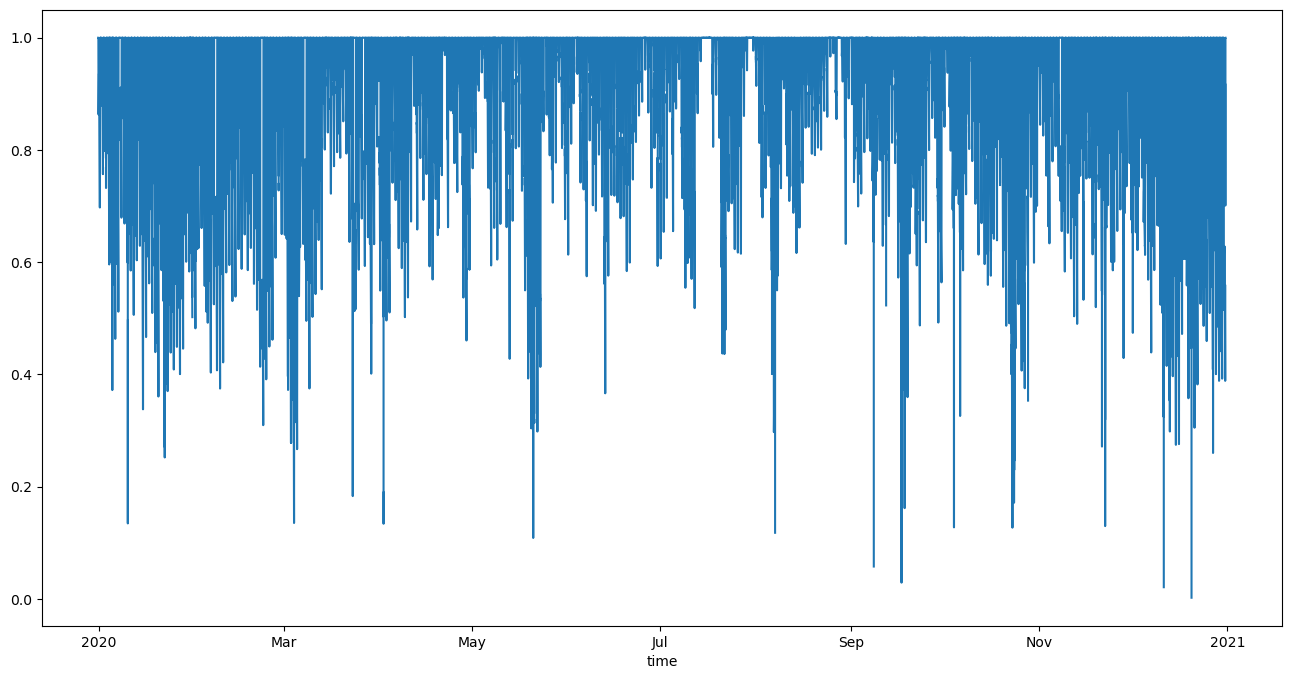

In [5]:
plt.figure(figsize=(16,8))
da.plot()

# Constant below threshold

In [6]:
da_droughts = xr.where(da < 0.5, 1, 0)

In [7]:
drought_lengths = [0]
for i_time in range(1, len(da_droughts)):
    drought_past = da_droughts[i_time - 1]
    drought_now = da_droughts[i_time]
    if (drought_now != 0) and (drought_past != 0):
        drought_now += drought_past
    drought_lengths.append(drought_now)

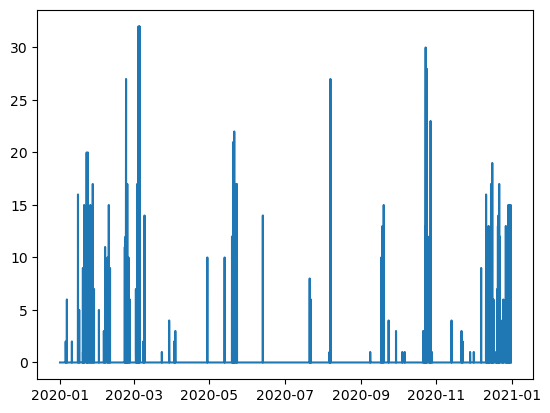

In [8]:
plt.plot(da.time.data, drought_lengths)

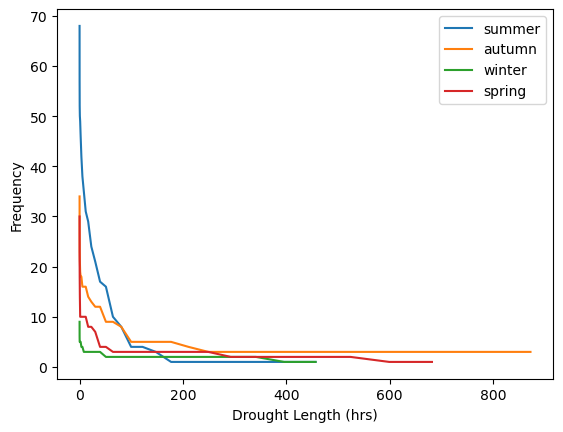

In [37]:
seasons = {
    'summer': [12,1,2],
    'autumn': [3,4,5],
    'winter': [6,7,8],
    'spring': [9,10,11]
}

for season in seasons:
    data = da_droughts.where(da_droughts.time.dt.month.isin(seasons[season]), drop=True)

    drought_lengths = [0]
    for i_time in range(1, len(data)):
        drought_past = data[i_time - 1]
        drought_now = data[i_time]
        if (drought_now != 0) and (drought_past != 0):
            drought_now += drought_past
        drought_lengths.append(drought_now)

    length, freq = np.unique(drought_lengths, return_counts = True)
    length = np.array(length[1:]) / 6
    freq = freq[1:]

    plt.plot(length, freq, label=season)
    plt.xlabel('Drought Length (hrs)')
    plt.ylabel('Frequency')
plt.legend()

# Mean Below Threshold

In [23]:
window = 3 # half hour mean period
rolling_mean = da.rolling(time=window, center=True).mean()

In [24]:
rolling_droughts = xr.where(rolling_mean < 0.5, 1, 0)

In [25]:
rolling_drought_lengths = [0]
for i_time in range(1, len(rolling_droughts)):
    drought_past = da_droughts[i_time - 1]
    drought_now = da_droughts[i_time]
    if (drought_now != 0) and (drought_past != 0):
        drought_now += drought_past
    rolling_drought_lengths.append(drought_now)

(18323.0, 18328.0)

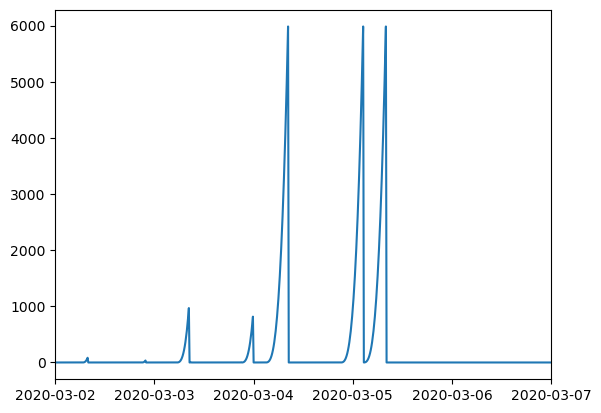

In [40]:
plt.plot(da.time.data, rolling_drought_lengths)
plt.xlim(pd.to_datetime('2020-03-02'), pd.to_datetime('2020-03-07'))

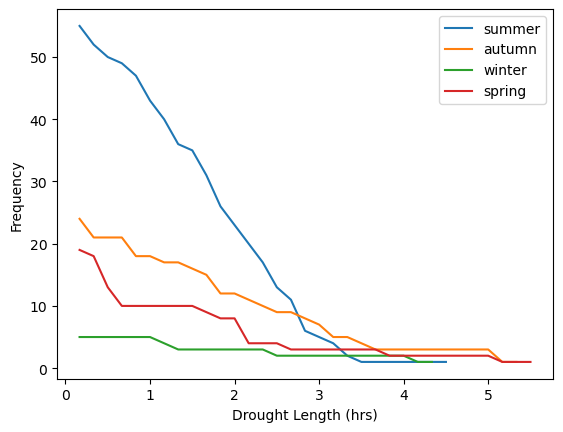

In [36]:
seasons = {
    'summer': [12,1,2],
    'autumn': [3,4,5],
    'winter': [6,7,8],
    'spring': [9,10,11]
}

for season in seasons:
    data = rolling_droughts.where(rolling_droughts.time.dt.month.isin(seasons[season]), drop=True)

    drought_lengths = [0]
    for i_time in range(1, len(data)):
        drought_past = data[i_time - 1]
        drought_now = data[i_time]
        if (drought_now != 0) and (drought_past != 0):
            drought_now += drought_past
        drought_lengths.append(drought_now)

    length, freq = np.unique(drought_lengths, return_counts = True)
    length = np.array(length[1:]) / 6
    freq = freq[1:]

    plt.plot(length, freq, label=season)
    plt.xlabel('Drought Length (hrs)')
    plt.ylabel('Frequency')
plt.legend()
plt.savefig('seasonal-frequency.png')